In [64]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

# Import necessary packages
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


#Data Preparation and Exploration

In [65]:
# Load the dataset
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'], index_col='date')

In [66]:
# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


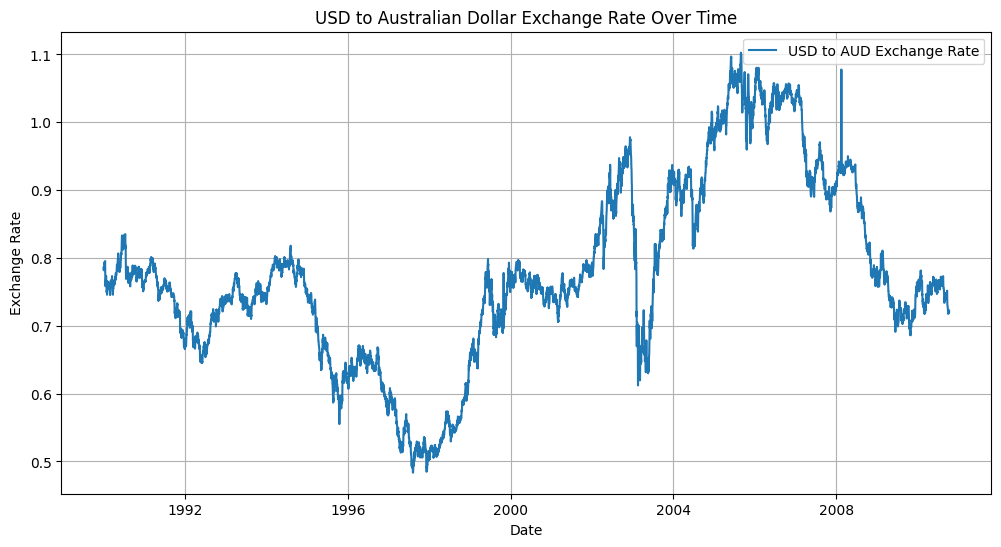

In [67]:
# Plot the time series for USD to Australian Dollar
df.index = pd.to_datetime(df.index, format='%d-%m-%Y %H:%M')

# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Ex_rate'], label='USD to AUD Exchange Rate')
plt.title('USD to Australian Dollar Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
df.shape

(7588, 1)

In [69]:
# Check missing values per column
df.isnull().sum()

,0
Ex_rate,0


In [70]:
# Forward fill (simple strategy)
df_filled = df.fillna(method='ffill')

# Verify that there are no missing values now
print("\nMissing values after forward-fill:")
print(df_filled.isnull().sum())


Missing values after forward-fill:
Ex_rate    0
dtype: int64


#Model Building - ARIMA

In [71]:
def test_stationarity(timeseries):

    # Calculate rolling mean and rolling standard deviation
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot original, rolling mean and rolling std
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean & Standard Deviation")
    plt.show()

    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:\n')

    df_test = adfuller(timeseries.dropna())

    my_output = pd.Series(df_test[0:4],
                          index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])

    for key, value in df_test[4].items():
        my_output[f'Critical Value ({key})'] = value

    print(my_output)

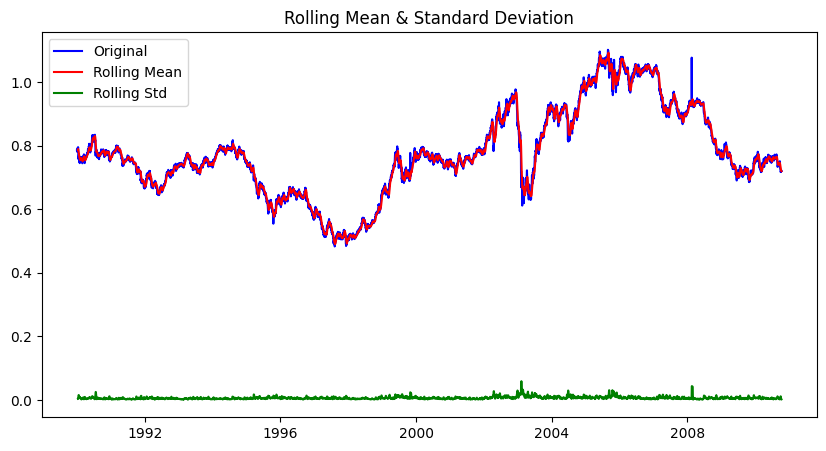

Results of Dickey-Fuller Test:

Test Statistic                   -1.664994
p-value                           0.449233
#Lags Used                        1.000000
Number of Observations Used    7586.000000
Critical Value (1%)              -3.431212
Critical Value (5%)              -2.861921
Critical Value (10%)             -2.566973
dtype: float64


In [72]:
test_stationarity(df['Ex_rate'])

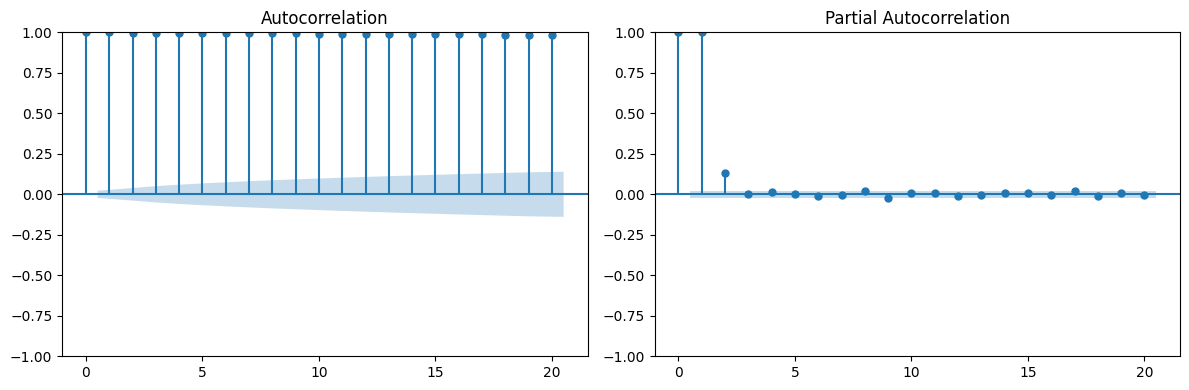

In [73]:
# Plot ACF and PACF
import statsmodels.tsa.api as smt

fig, axes = plt.subplots(1, 2, figsize=(12,4))
smt.graphics.plot_acf(df['Ex_rate'].dropna(), lags=20, ax=axes[0])
smt.graphics.plot_pacf(df['Ex_rate'].dropna(), lags=20, ax=axes[1], method='ywm')
plt.tight_layout()
plt.show()


In [74]:
from statsmodels.tsa.arima.model import ARIMA

# Split the data
train_size = int(len(df_filled) * 0.8)
train = df_filled['Ex_rate'][:train_size]
test = df_filled['Ex_rate'][train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

In [75]:
# Print summary
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 6070
Model:                 ARIMA(1, 1, 1)   Log Likelihood               22719.046
Date:                Thu, 12 Feb 2026   AIC                         -45432.092
Time:                        10:26:38   BIC                         -45411.959
Sample:                    01-01-1990   HQIC                        -45425.104
                         - 08-14-2006                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5972      0.062     -9.648      0.000      -0.719      -0.476
ma.L1          0.5398      0.064      8.430      0.000       0.414       0.665
sigma2      3.281e-05   1.95e-07    168.198      0.0

Parameter Selection

d = 1
Because the original time series was non-stationary (ADF test p-value > 0.05), so first-order differencing was applied to make the series stationary.

p = 2
Selected based on the PACF plot, where significant spikes were observed up to lag 2, suggesting an AR(2) component.

q = 2
Selected based on the ACF plot, where significant spikes were observed up to lag 2, suggesting an MA(2) component.

Model Fitting:
An ARIMA(p, d, q) model with the selected parameters was fitted on the training dataset.

In [76]:
df.columns

Index(['Ex_rate'], dtype='object')

Diagnostics

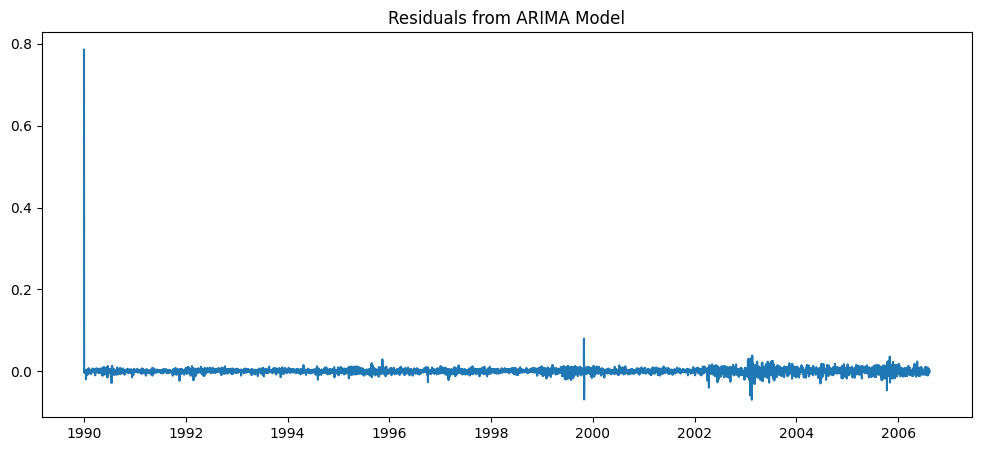

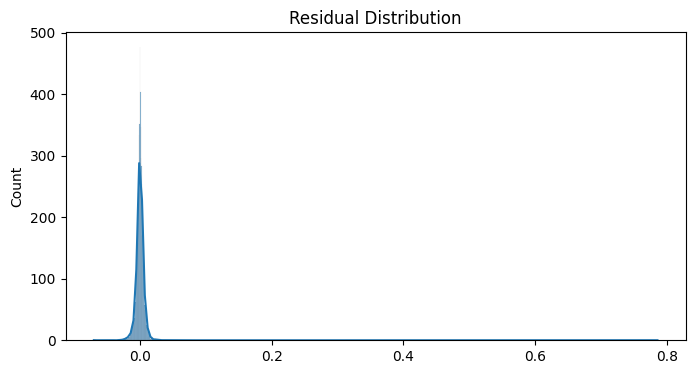

In [77]:
# Extract residuals
residuals = arima_result.resid

# Plot residuals
plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title("Residuals from ARIMA Model")
plt.show()

# Distribution plot
plt.figure(figsize=(8,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()


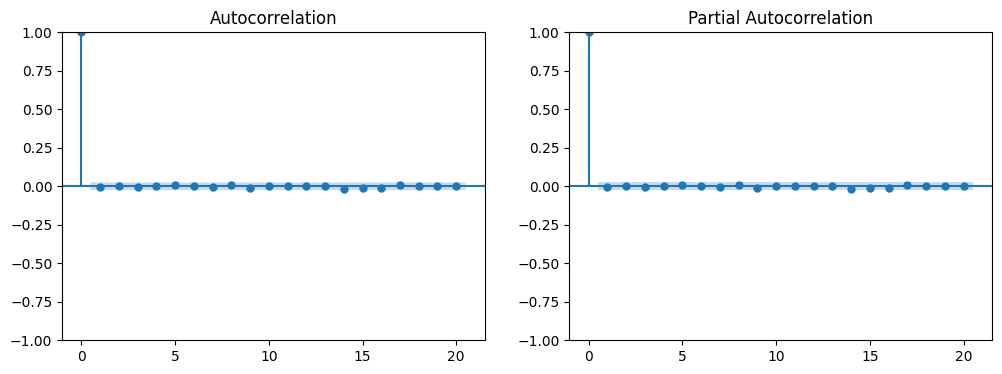

In [78]:
# ACF of ARIMA Residual
# Residual=Actual−Predicted
import statsmodels.api as sm

fig, ax = plt.subplots(1,2, figsize=(12,4))

sm.graphics.tsa.plot_acf(residuals, lags=20, ax=ax[0])
sm.graphics.tsa.plot_pacf(residuals, lags=20, ax=ax[1])

plt.show()


Spikes outside confidence bounds → model missing structure

Mostly inside bounds → good fit

p-value < 0.05 → Reject H₀ → BAD model

p-value > 0.05 → Fail to reject H₀ → GOOD model

*The obtained p-value (0.998) is significantly greater than 0.05, indicating failure to reject the null hypothesis. This suggests the residuals are independently distributed and resemble white noise, confirming that the ARIMA model has adequately captured the underlying temporal dependencies.*

In [79]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(lb)


     lb_stat  lb_pvalue
10  1.647217   0.998399


Forecasting

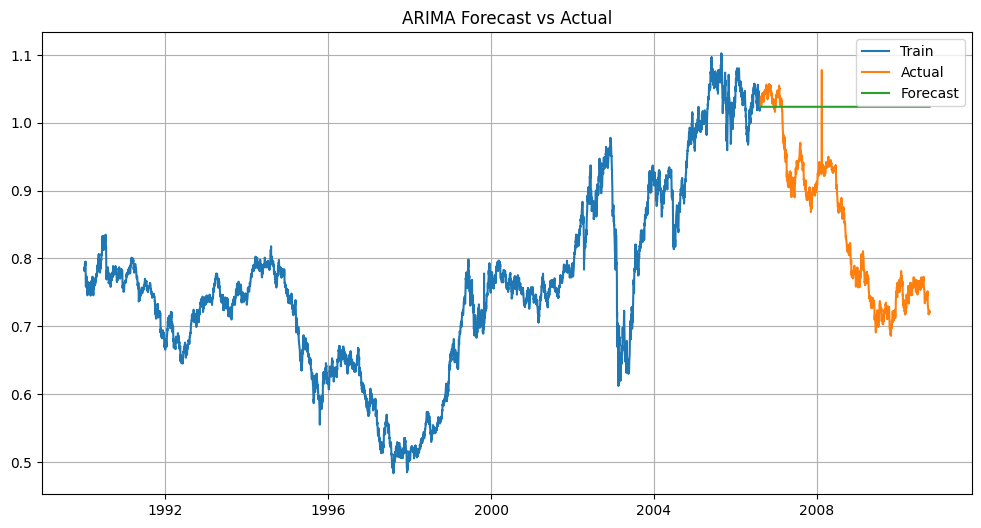

In [80]:
forecast = arima_result.forecast(steps=len(test))

plt.figure(figsize=(12,6))

# Plot the forecast against actual values
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Forecast")

plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.grid(True)
plt.show()


In [81]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = np.mean(np.abs((test - forecast) / test)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

MAE: 0.17770970449121345
RMSE: 0.2054366965966928
MAPE: 22.797966173811552


# Evaluation and Comparison

Holt’s Linear Trend Model

Exploratory analysis showed a clear trend but no repeating seasonal pattern in the exchange-rate series.

Holt’s Linear model captures level and trend, whereas Simple ES ignores trend and Holt-Winters adds unnecessary seasonality.



In [82]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

holt_model = ExponentialSmoothing(
    train,trend="add",seasonal=None
).fit()

configs = [
    {"trend": "add"},
    {"trend": "mul"},
]

best_aic = float("inf")
best_model = None
best_cfg = None

for cfg in configs:
    try:
        model = ExponentialSmoothing(
            train,trend=cfg["trend"],seasonal=None
        ).fit()

        if model.aic < best_aic:
            best_aic = model.aic
            best_model = model
            best_cfg = cfg

    except:
        continue
print("AIC:", holt_model.aic)
print("Best Config:", best_cfg)
print("Best AIC:", best_aic)


AIC: -62655.663449991844
Best Config: {'trend': 'add'}
Best AIC: -62655.663449991844


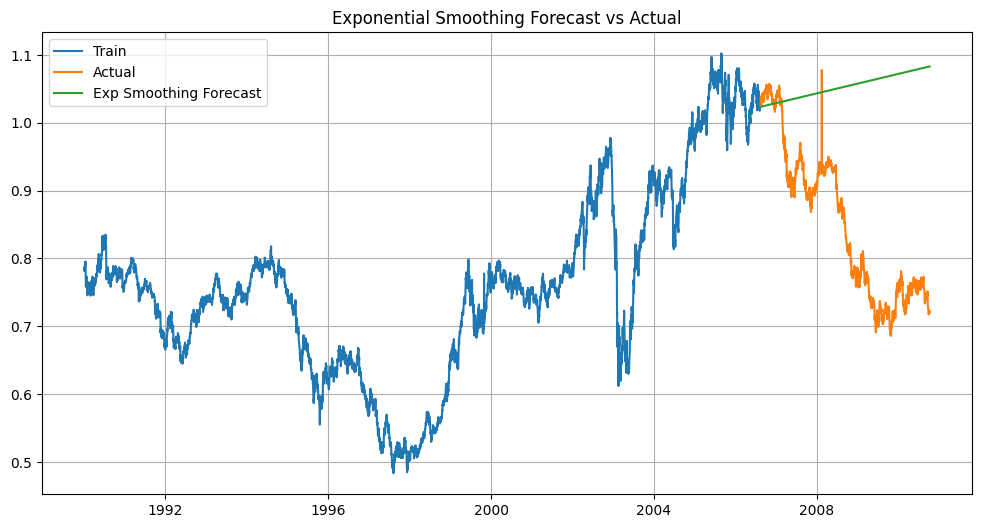

In [83]:
exp_model = best_model
exp_forecast = exp_model.forecast(len(test))

plt.figure(figsize=(12,6))

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, exp_forecast, label="Exp Smoothing Forecast")

plt.legend()
plt.title("Exponential Smoothing Forecast vs Actual")
plt.grid(True)
plt.show()


In [84]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_exp = mean_absolute_error(test, exp_forecast)
rmse_exp = np.sqrt(mean_squared_error(test, exp_forecast))
mape_exp = np.mean(np.abs((test-exp_forecast)/test))*100

print("MAE:", mae_exp)
print("RMSE:", rmse_exp)
print("MAPE:", mape_exp)


MAE: 0.20659619114093827
RMSE: 0.23910443161792286
MAPE: 26.50866379878783


In [85]:
def get_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = np.mean(np.abs((actual - pred)/actual)) * 100
    return mae, rmse, mape



arima_mae, arima_rmse, arima_mape = get_metrics(test, forecast)
exp_mae, exp_rmse, exp_mape = get_metrics(test, exp_forecast)

comparison = pd.DataFrame({
    "Model":["ARIMA","Exponential Smoothing"],
    "MAE":[arima_mae, exp_mae],
    "RMSE":[arima_rmse, exp_rmse],
    "MAPE":[arima_mape, exp_mape]
})

comparison

,Model,MAE,RMSE,MAPE
0,ARIMA,0.177710,0.205437,22.797966
1,Exponential Smoothing,0.206596,0.239104,26.508664


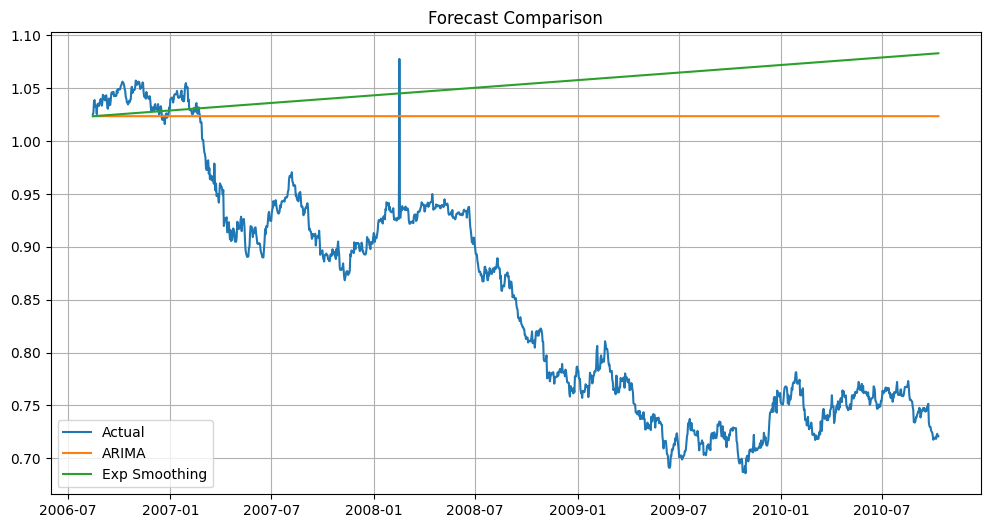

In [86]:
plt.figure(figsize=(12,6))

plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="ARIMA")
plt.plot(test.index, exp_forecast, label="Exp Smoothing")

plt.legend()
plt.title("Forecast Comparison")
plt.grid(True)
plt.show()

# Report

This study aimed to forecast USD to AUD exchange rates using time series techniques, specifically ARIMA and Exponential Smoothing models. Historical exchange rate data were loaded, visualized, and preprocessed by handling missing values and converting the date column to a proper time index. Exploratory analysis indicated the presence of a trend component with no clear seasonal pattern.

An ARIMA model was developed by selecting parameters using ACF and PACF analysis, followed by model fitting and residual diagnostics. The Ljung–Box test confirmed that residuals exhibited no significant autocorrelation, indicating that the model adequately captured temporal dependencies. Forecasting using ARIMA produced error metrics of MAE = 0.178, RMSE = 0.205, and MAPE = 22.80%.

Exponential Smoothing modeling was conducted using Holt’s Linear approach due to the observed trend without seasonality. Parameter selection was performed using AIC comparison, and forecasts were generated. This model resulted in MAE = 0.207, RMSE = 0.239, and MAPE = 26.51%.

Comparative evaluation showed that the ARIMA model consistently achieved lower forecasting errors than Exponential Smoothing, demonstrating superior predictive accuracy for this dataset. This indicates that modeling autocorrelation structure is more effective for exchange-rate forecasting than relying solely on smoothing-based trend estimation.

Overall, the exercise demonstrated the practical application of time-series modeling techniques and highlighted the importance of aligning model choice with observed data characteristics.